In [1]:
import bt
import FinanceDataReader as fdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns

# pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from IPython.display import display, HTML
"%config InlineBackend.figure_format = 'retina'"

#하나의 cell에서 multiple output을 출력을 가능하게 하는 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Pandas Dataframe의 사이즈가 큰 경우, 어떻게 화면에 출력을 할지를 세팅하는 코드
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from strategy import*
from utils import *

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [4]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)

https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1086

주기를 월로 해서 다운로드한다. (2001년 1월~)

외국인 보유금액 : 금융감독원에 투자 등록한 외국인이 취득한 상장 주식의 기준일 현재 시가로 평가한 금액

보유금액 > 유가증권시장 사용

(1) 한달 lag(shift(1)) 한다.
 - 1월의 데이터가 1월 마지막날 데이터이고 2월 1일 리밸런싱시에 사용하기

## 데이터 수정 버전 (2021-11-21)
이전 백테스팅에 사용했던 외국인수급 데이터인 

index.go.kr에서 받은 데이터의 "외국인 보유금액: 금융감독원에 투자 등록한 외국인이 취득한 상장 주식의 기준일 현재 시가로 평가한 금액" 으로 이것은 백테스트와 맞지 않는다.

아래 대신증권에서 받은 "월별투자자별매매동향대신.csv" 로 변경하여 테스트하면 결과가 많이 다르다.

해당 데이터는 투자자별매매동향을 HTS로 부터 받은 다음 cumsum한 후 매월말 데이터를 추출한 것이다.

* 참고 
- 영웅문의 경우 2003년부터 데이터가 존재하고 대신증권의 경우 1998-3-31일 부터 존재한다.

In [5]:
dd = pd.read_csv('일별투자자별매매동향대신.csv', index_col=0, parse_dates=True)

In [6]:
외국인수급 = dd.loc['2000':'2021-08', '외국인'].copy().to_frame()
외국인수급.columns = ['kospi']

<AxesSubplot:xlabel='일자'>

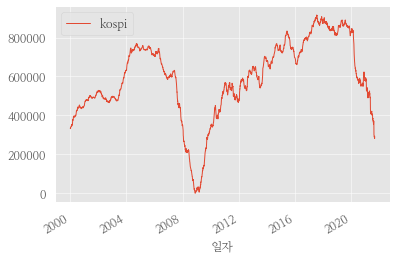

In [7]:
외국인수급 = 외국인수급 - 외국인수급.min()
외국인수급.plot()

In [8]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1])

<AxesSubplot:xlabel='일자'>

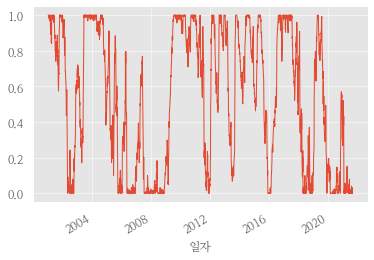

In [9]:
외국인수급['ams'] = 외국인수급['kospi'].rolling(252).apply(AMS)
외국인수급['ams'].plot()

In [21]:
target_weights = pd.DataFrame()
target_weights['ams'] = 외국인수급['ams']
target_weights['현금'] = 1.0 - target_weights


In [22]:
target_weights = target_weights.dropna()
target_weights = target_weights.resample('D').fillna(method='ffill').shift(1)

<AxesSubplot:>

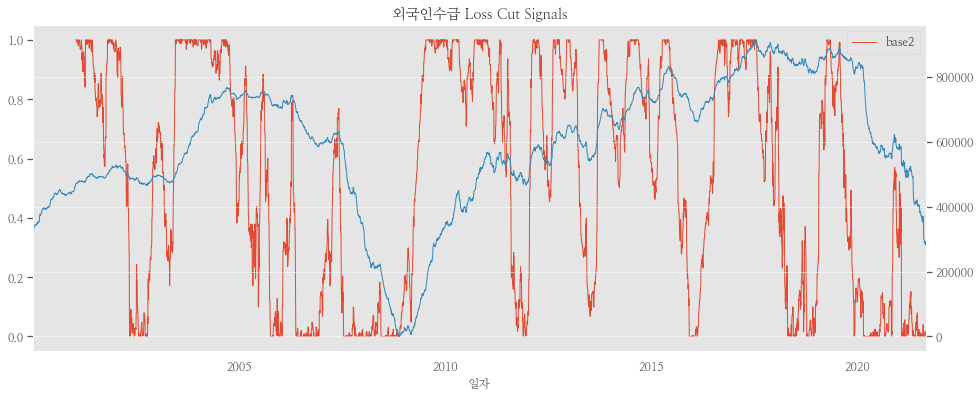

In [23]:
target_weights.columns = ['base2', '현금'] 
# target_weights.to_csv('한국Base2비중.csv')
ax = target_weights['base2'].plot(figsize=(16,6), title='외국인수급 Loss Cut Signals', legend=True);
외국인수급['kospi'].plot(ax=ax, secondary_y=True)

In [24]:
# target_weights.to_csv('ID2_tw.csv')
# 외국인수급.to_csv('ID2_외국인수급.csv')

In [25]:
tickers = list(prices.columns[:-4])+['현금'] 
print(tickers)

['MKF500', '에너지', '화학', '금속및광물', '기타 소재', '건설', '조선', '기타자본재', '상업서비스', '운송', '자동차및부품', '내구소비재및의류', '소비자서비스', '미디어', '유통', '음식료및담배', '생활용품', '의료', '은행', '보험', '증권', '기타금융', '소프트웨어', '하드웨어', '반도체', '디스플레이', '통신서비스', '유틸리티', '코스피200', '코스닥', '현금']


In [26]:
base2 = bt.Strategy(
    'base2', 
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(), bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0)),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance() 
    ] 
)
# %%
bt_id2 = bt.Backtest(base2, prices) 
r_id2 = bt.run(bt_id2)

In [27]:
kbase2 = bt.Strategy(
    'kbase2',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)
# %%
bt_kbase2 = bt.Backtest(kbase2, prices) 
r = bt.run(bt_id2, bt_kbase2)

In [28]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 base2       kbase2
-------------------  ----------  ----------
Start                2002-02-01  2002-02-01
End                  2020-07-02  2020-07-02
Risk-free rate       0.00%       0.00%

Total Return         913.59%     804.24%
Daily Sharpe         0.49        0.66
Daily Sortino        0.76        1.02
CAGR                 13.40%      12.70%
Max Drawdown         -57.72%     -30.82%
Calmar Ratio         0.23        0.41

MTD                  1.93%       0.01%
3m                   32.71%      0.66%
6m                   20.24%      0.90%
YTD                  19.84%      0.87%
1Y                   17.71%      -2.66%
3Y (ann.)            -1.04%      -5.33%
5Y (ann.)            0.32%       0.57%
10Y (ann.)           8.81%       9.37%
Since Incep. (ann.)  13.40%      12.70%

Daily Sharpe         0.49        0.66
Daily Sortino        0.76        1.02
Daily Mean (ann.)    11.41%      9.24%
Daily Vol (ann.)     23.37%      14.07%
Daily Skew           -0.08       0.06
Dai

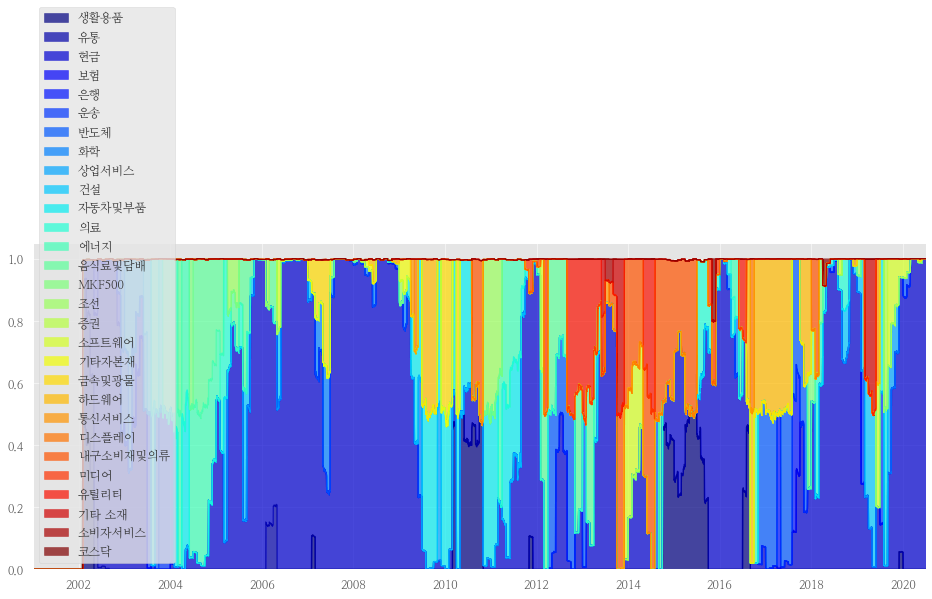

In [29]:
r.get_security_weights('kbase2').plot.area(stacked=True, alpha=0.7, legend=True, cmap='jet', figsize=(16,6));

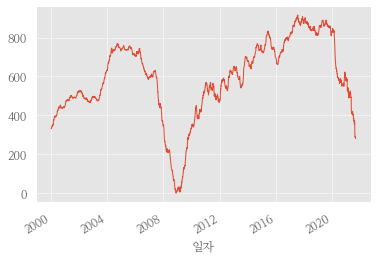

In [30]:
(외국인수급['kospi']/1000).plot(label='외국인수급');

In [31]:
kospi = fdr.DataReader('KS11', '2001', '2021-08')['Close'].rename('KOSPI')

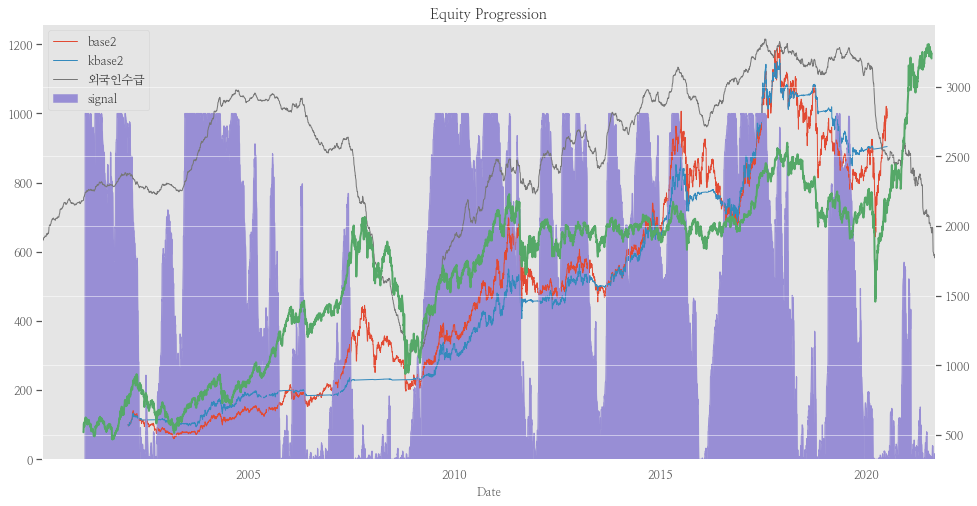

In [32]:
ax = r.plot(figsize=(16,8));
(target_weights['base2']*1000).plot.area(ax=ax, label='signal');
(외국인수급['kospi']/1000+300).plot(ax=ax, label='외국인수급');
plt.legend(loc="upper left");

kospi.plot(ax=ax, lw=2, color='g', secondary_y = True, label='KOSPI');

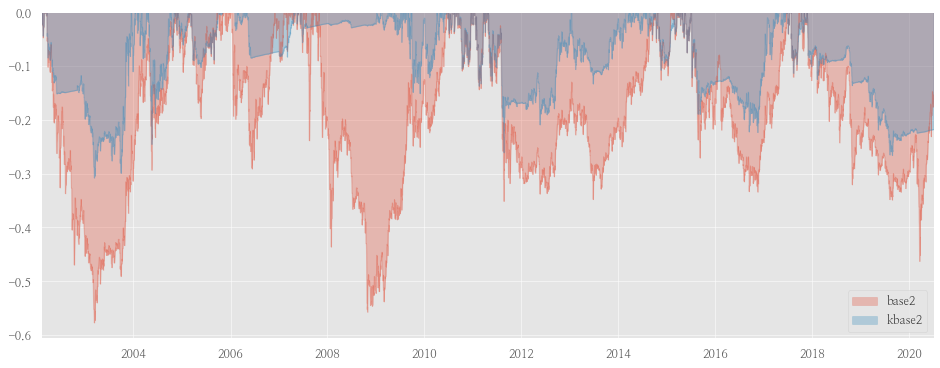

In [33]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

In [26]:
# bt_kbase2.positions.to_csv('한국ID2상대모멘텀_포지션.csv')